In [13]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#Using newest versions of all libraries

In [14]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [24]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_M8", "BH_M10", "BH_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
#"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"

FOLDERS = ["sph", "BH", "BH", "BH"]

"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"] #The labels in the hdf5 dataset
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #For plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
CUT=True"""

CUT=True
#Set data paths
if CUT:
    N_EVENTS = [10000, 10000, 10000, 10000]
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = [10000, 10000, 10000, 10000]
    TRAIN_FILENAMES = [f"{label}_res{RES}_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

SAVE_PATH = "../results"
#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)

filters=None

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")


resnet_1679485495_SPH_9_BH_M8_BH_M10_BH_M12_CUT
Running on the GPU


In [16]:

testpaths = [Path(path) for path in TEST_DATAPATHS]

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)

#test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)

df_labels = ["n", "resolution", "training samples", "epochs", "learning rate", "transforms", "filters", "mean accuracy", "std accuracy"]

results = pd.DataFrame(columns=df_labels)

transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )


Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 3000 events out of 3000.


In [17]:

def experiment(df, testdata, n_train, n, epochs, lr, transforms):
    scores = np.zeros(n)

    """traindata = Hdf5Dataset(TRAIN_DATAPATH, LABELS, DEVICE, 
                        shuffle=True, transform=transforms, event_limit=n_train)
    """
    trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
    traindata = load_datasets(trainpaths, DEVICE, n_train, filters, transforms)
    #traindata = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                       # shuffle=True, transform=transforms, event_limit=n_train)
    for i in range(n):
        print(f"Iteration {i}")
        resnet = ResNet18(img_channels=3, num_classes=CLASSES)
        resnet.to(DEVICE)
        optimizer = optim.Adam(resnet.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=lr*10, step_size_up=5, mode="exp_range", gamma=0.85, cycle_momentum=False)
        training_results = train(resnet, traindata, testdata, 2**8, epochs, RES, DEVICE, optimizer, scheduler)
        truth, preds = predict(resnet, testdata, CLASSES, 1, RES, DEVICE)
        accuracy = accuracy_score(truth, preds, normalize=True)
        scores[i]= accuracy
        print(f"Accuracy: {accuracy}")
    data = {"n":n, 
            "resolution": RES,
            "training samples": len(traindata), 
            "epochs" : epochs, 
            "learning rate" : lr, 
            "transforms"  : [transforms], 
            "filters" : filters, 
            "mean accuracy" : scores.mean(), 
            "std accuracy" : scores.std()}
    new_data = pd.DataFrame(data)
    new_df = pd.concat([df, new_data], ignore_index=True)
    return new_df, training_results, resnet


In [18]:
#Run n experiments to find statistics on accuracy

results, training_results, resnet = experiment(df=results, n_train=10000, testdata=test_data, 
                                                n=10, epochs=40, lr=0.001, transforms=transforms)

Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters None
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 15630.7041015625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 18992.416015625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 24906.041015625.
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 31944.91796875.
Data has shape torch.Size([50, 50, 3])
There are 4 classes.
Iteration 0


100%|██████████| 12000/12000 [01:28<00:00, 135.31it/s]


Accuracy: 0.7426666666666667
Iteration 1


100%|██████████| 12000/12000 [01:22<00:00, 145.70it/s]


Accuracy: 0.74
Iteration 2


100%|██████████| 12000/12000 [01:32<00:00, 130.04it/s]


Accuracy: 0.7346666666666667
Iteration 3


100%|██████████| 12000/12000 [01:28<00:00, 136.12it/s]


Accuracy: 0.7523333333333333
Iteration 4


100%|██████████| 12000/12000 [01:21<00:00, 146.79it/s]


Accuracy: 0.7538333333333334
Iteration 5


100%|██████████| 12000/12000 [01:21<00:00, 146.61it/s]


Accuracy: 0.7290833333333333
Iteration 6


100%|██████████| 12000/12000 [01:26<00:00, 138.86it/s]


Accuracy: 0.7608333333333334
Iteration 7


100%|██████████| 12000/12000 [01:36<00:00, 124.26it/s]


Accuracy: 0.7466666666666667
Iteration 8


100%|██████████| 12000/12000 [01:24<00:00, 142.09it/s]


Accuracy: 0.7204166666666667
Iteration 9


100%|██████████| 12000/12000 [01:26<00:00, 139.33it/s]

Accuracy: 0.6958333333333333


In [19]:
results

,n,resolution,training samples,epochs,learning rate,transforms,filters,mean accuracy,std accuracy
0,10,50,40000,40,0.001,"[RandomVerticalFlip(p=0.5), RandomRoll()]",None,0.737633,0.018041


In [21]:
results.to_csv(f"{SAVE_PATH}/{MODEL_NAME}_results.csv")
results.to_pickle(f"{SAVE_PATH}/{MODEL_NAME}_results.pkl")

(0.0, 1.0)

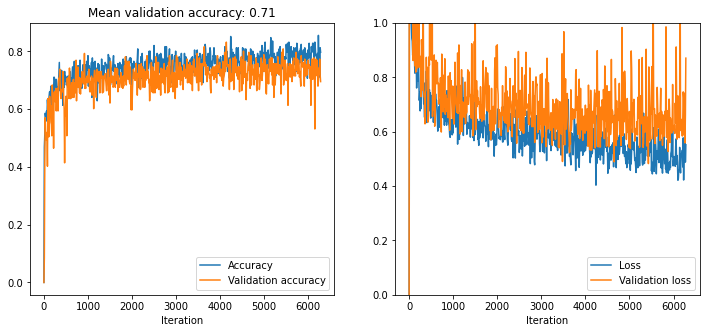

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[1].set_ylim(0, 1)

100%|██████████| 12000/12000 [01:28<00:00, 135.05it/s]


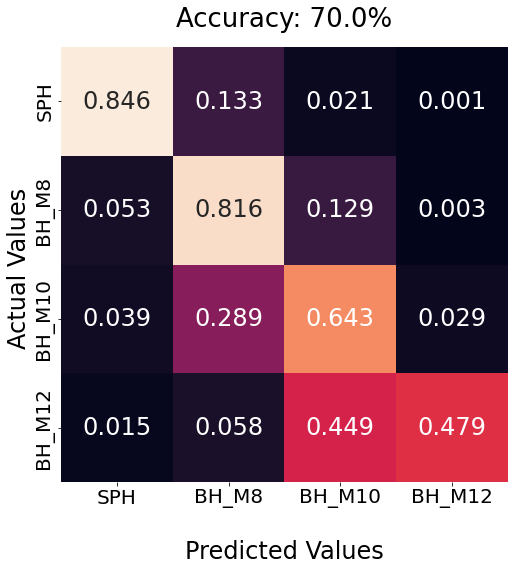

In [23]:
truth, preds = predict(resnet, test_data, CLASSES, 1, RES, DEVICE)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

[0.846 0.133 0.021 0.001 0.053 0.816 0.129 0.003 0.039 0.289 0.643 0.029
 0.015 0.058 0.449 0.479]


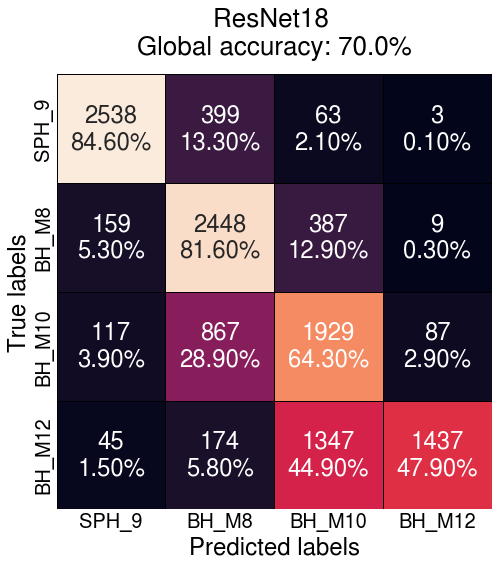

In [25]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()   
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(8, 8))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)